### TED Talk Analysis
##### Name: Wei Cui
##### unique name: viviannn

In [111]:
%matplotlib inline
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('en')
import gensim
import re
from spacy.lang.en.stop_words import STOP_WORDS
import string

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Data Preparation

In [112]:
talks_df  = pd.read_csv('ted-talks/ted_main.csv')
talks_df.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520


In [113]:
type(talks_df.views[0])

numpy.int64

In [114]:
talks_df.shape

(2550, 17)

In [115]:
len(talks_df['event'].unique())

355

In [116]:
talks_df.count()

comments              2550
description           2550
duration              2550
event                 2550
film_date             2550
languages             2550
main_speaker          2550
name                  2550
num_speaker           2550
published_date        2550
ratings               2550
related_talks         2550
speaker_occupation    2544
tags                  2550
title                 2550
url                   2550
views                 2550
dtype: int64

### Q1: What are the popular TED talks look like?

In [117]:
tags_split_df_prep = pd.DataFrame(talks_df['tags']).unstack().str.strip("['']").str.split("', '", expand=True)
tags_split_df_prep2 = tags_split_df_prep.reset_index()

tags_split_df_prep3 = tags_split_df_prep2.merge(talks_df, left_index = True, right_index = True)
tags_split_df_prep3.columns

tags_split_df = tags_split_df_prep3.melt(id_vars = ['level_0','level_1','comments','description','duration','event','film_date','languages','main_speaker','name','num_speaker','published_date','ratings','related_talks', 'speaker_occupation','tags','title','url','views'], value_name = "tag")
tags_split_df.tag = tags_split_df.tag.str.lower()

In [118]:
tags_split_df.head()

,level_0,level_1,comments,description,duration,event,film_date,languages,main_speaker,name,...,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,variable,tag
0,tags,0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,...,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,0,children
1,tags,1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,...,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,0,alternative energy
2,tags,2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,...,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,0,computers
3,tags,3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,...,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,0,macarthur grant
4,tags,4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,...,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,0,africa


In [119]:
tags_split_df[tags_split_df['tag']=='testing']

,level_0,level_1,comments,description,duration,event,film_date,languages,main_speaker,name,...,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,variable,tag
11702,tags,1502,634,Sir Ken Robinson outlines 3 principles crucial...,1151,TED Talks Education,1366675200,43,Ken Robinson,Ken Robinson: How to escape education's death ...,...,1368198532,"[{'id': 21, 'name': 'Unconvincing', 'count': 2...","[{'id': 66, 'hero': 'https://pe.tedcdn.com/ima...",Author/educator,"['culture', 'education', 'student', 'teaching'...",How to escape education's death valley,https://www.ted.com/talks/ken_robinson_how_to_...,6657858,4,testing


In [120]:
popular_view_df = tags_split_df.copy()
popular_view_group = popular_view_df.groupby('tag').mean().sort_values(by=['views'],ascending=False)
popular_view_group.head(10)

,level_1,comments,duration,film_date,languages,num_speaker,published_date,views
tag,,,,,,,,
body language,1162.636364,465.727273,882.090909,1.290926e+09,36.454545,1.00,1.330331e+09,7.993455e+06
testing,1502.000000,634.000000,1151.000000,1.366675e+09,43.000000,1.00,1.368199e+09,6.657858e+06
success,1630.107143,377.535714,703.785714,1.378919e+09,36.535714,1.00,1.389064e+09,6.454557e+06
introvert,1379.400000,408.400000,831.600000,1.323769e+09,37.600000,1.00,1.356308e+09,6.303976e+06
mindfulness,1977.200000,143.800000,779.400000,1.410065e+09,29.600000,1.00,1.432933e+09,4.335877e+06
evil,352.000000,331.500000,1189.500000,1.217938e+09,34.500000,1.00,1.229692e+09,4.283967e+06
dance,1154.120000,346.440000,795.800000,1.296480e+09,30.200000,1.36,1.325629e+09,4.122717e+06
productivity,1681.850000,197.900000,730.600000,1.385506e+09,34.150000,1.00,1.395742e+09,4.048263e+06
addiction,2295.800000,202.600000,713.200000,1.466536e+09,24.000000,1.00,1.474903e+09,4.033930e+06


In [121]:
view_top_10 = popular_view_group.head(10)[['views','comments']]

(-1, 10)

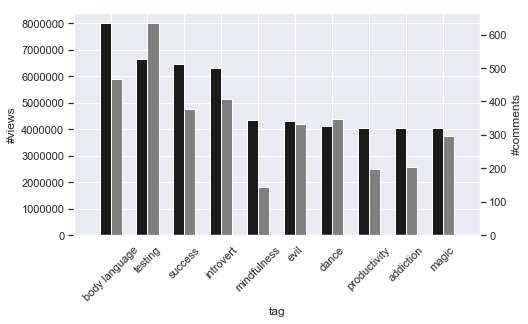

In [122]:
import seaborn as sns
sns.set()
import matplotlib.pylab as plt

fig = plt.figure(figsize=(16,9)) # Create matplotlib figure

ax = fig.add_subplot(222) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .3

view_top_10.views.plot(kind='bar',color='k',ax=ax,width=width, position=1)
view_top_10.comments.plot(kind='bar',color='grey', ax=ax2,width = width,position=0)

ax.grid(None, axis=1)
ax2.grid(None)

ax.set_ylabel('#views')
ax2.set_ylabel('#comments')

ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

ax.set_xlim(-1,10)

In [123]:
popular_comments_df = tags_split_df.copy()
popular_comments_group = popular_view_df.groupby('tag').mean().sort_values(by=['comments'],ascending=False)
popular_comments_group.head(10)

,level_1,comments,duration,film_date,languages,num_speaker,published_date,views
tag,,,,,,,,
atheism,598.200000,1991.200000,1253.400000,1.200563e+09,35.200000,1.000000,1.242421e+09,2.897008e+06
god,751.812500,878.562500,1041.000000,1.219625e+09,27.125000,1.000000,1.269811e+09,2.217166e+06
suicide,1262.250000,643.750000,875.000000,1.305299e+09,34.625000,1.000000,1.340408e+09,3.606270e+06
testing,1502.000000,634.000000,1151.000000,1.366675e+09,43.000000,1.000000,1.368199e+09,6.657858e+06
evolutionary psychology,817.800000,584.600000,1153.300000,1.216918e+09,27.500000,1.100000,1.284956e+09,2.489231e+06
religion,1112.892857,569.410714,1058.910714,1.292616e+09,27.821429,1.017857,1.321117e+09,1.653761e+06
novel,698.333333,532.000000,1941.000000,1.218614e+09,22.000000,1.000000,1.275934e+09,1.921858e+06
consciousness,1118.666667,506.416667,1020.166667,1.296068e+09,29.000000,1.041667,1.322071e+09,2.840933e+06
christianity,1217.833333,492.333333,1152.333333,1.267258e+09,26.666667,1.000000,1.327585e+09,2.407894e+06


In [124]:
comment_top_10 = popular_comments_group.head(10)[['views','comments']]

(-1, 10)

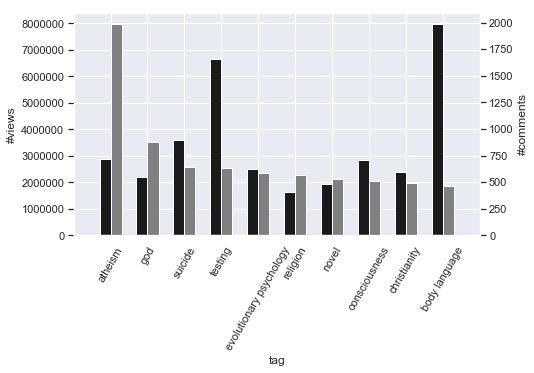

In [125]:
import seaborn as sns
sns.set()
import matplotlib.pylab as plt

fig = plt.figure(figsize=(16,9)) # Create matplotlib figure

ax = fig.add_subplot(222) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .3

comment_top_10.views.plot(kind='bar',color='k',ax=ax,width=width, position=1)
comment_top_10.comments.plot(kind='bar',color='grey', ax=ax2,width = width,position=0)

ax.grid(None, axis=1)
ax2.grid(None)

ax.set_ylabel('#views')
ax2.set_ylabel('#comments')

ax.set_xticklabels(ax.get_xticklabels(),rotation=60)

ax.set_xlim(-1,10)

In [126]:
popular_c_v_df = talks_df.copy()
popular_c_v_df['c/v'] = popular_c_v_df['comments']/popular_c_v_df['views']
popular_c_v_sort = popular_c_v_df.sort_values(by=['c/v'],ascending=False)
popular_c_v_top = popular_c_v_sort.head(100)
popular_c_v_top.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,c/v
744,649,Hours before New York lawmakers rejected a key...,453,New York State Senate,1259712000,0,Diane J. Savino,Diane J. Savino: The case for same-sex marriage,1,1282062180,"[{'id': 25, 'name': 'OK', 'count': 100}, {'id'...","[{'id': 217, 'hero': 'https://pe.tedcdn.com/im...",Senator,"['God', 'LGBT', 'culture', 'government', 'law'...",The case for same-sex marriage,https://www.ted.com/talks/diane_j_savino_the_c...,292395,0.002220
803,834,David Bismark demos a new system for voting th...,422,TEDGlobal 2010,1279065600,36,David Bismark,David Bismark: E-voting without fraud,1,1288685640,"[{'id': 25, 'name': 'OK', 'count': 111}, {'id'...","[{'id': 803, 'hero': 'https://pe.tedcdn.com/im...",Voting system designer,"['culture', 'democracy', 'design', 'global iss...",E-voting without fraud,https://www.ted.com/talks/david_bismark_e_voti...,543551,0.001534


In [127]:
popular_c_v_top.shape

(100, 18)

In [128]:
cv_tags_split_df_prep = pd.DataFrame(popular_c_v_top['tags']).unstack().str.strip("['']").str.split("', '", expand=True)
# cv_tags_split_df_prep2 = cv_tags_split_df_prep.reset_index()
cv_tags_split_df_prep2 = cv_tags_split_df_prep.reset_index(level=0, drop=True)
cv_tags_split_df_prep2.head(2)
cv_tags_split_df_prep3 = cv_tags_split_df_prep2.merge(popular_c_v_top, left_index = True, right_index = True)
# cv_tags_split_df_prep3.columns
cv_tags_split_df_prep3.shape
cv_tags_split_df = cv_tags_split_df_prep3.melt(id_vars = ['comments','description','duration','event','film_date','languages','main_speaker','name','num_speaker','published_date','ratings','related_talks', 'speaker_occupation','tags','title','url','views','c/v'], value_name = "tag")
cv_tags_split_df.tag = cv_tags_split_df.tag.str.lower()

In [129]:
cv_tags_split_df.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,c/v,variable,tag
0,649,Hours before New York lawmakers rejected a key...,453,New York State Senate,1259712000,0,Diane J. Savino,Diane J. Savino: The case for same-sex marriage,1,1282062180,"[{'id': 25, 'name': 'OK', 'count': 100}, {'id'...","[{'id': 217, 'hero': 'https://pe.tedcdn.com/im...",Senator,"['God', 'LGBT', 'culture', 'government', 'law'...",The case for same-sex marriage,https://www.ted.com/talks/diane_j_savino_the_c...,292395,0.002220,0,god
1,834,David Bismark demos a new system for voting th...,422,TEDGlobal 2010,1279065600,36,David Bismark,David Bismark: E-voting without fraud,1,1288685640,"[{'id': 25, 'name': 'OK', 'count': 111}, {'id'...","[{'id': 803, 'hero': 'https://pe.tedcdn.com/im...",Voting system designer,"['culture', 'democracy', 'design', 'global iss...",E-voting without fraud,https://www.ted.com/talks/david_bismark_e_voti...,543551,0.001534,0,culture


In [130]:
cv_tags_split_df.shape

(2000, 20)

In [131]:
tag_group = cv_tags_split_df.copy()
tag_grouped = tag_group.groupby('tag').size().reset_index()
tag_grouped = tag_grouped.sort_values(0, ascending=False).set_index('tag').head(50)

(-1, 50)

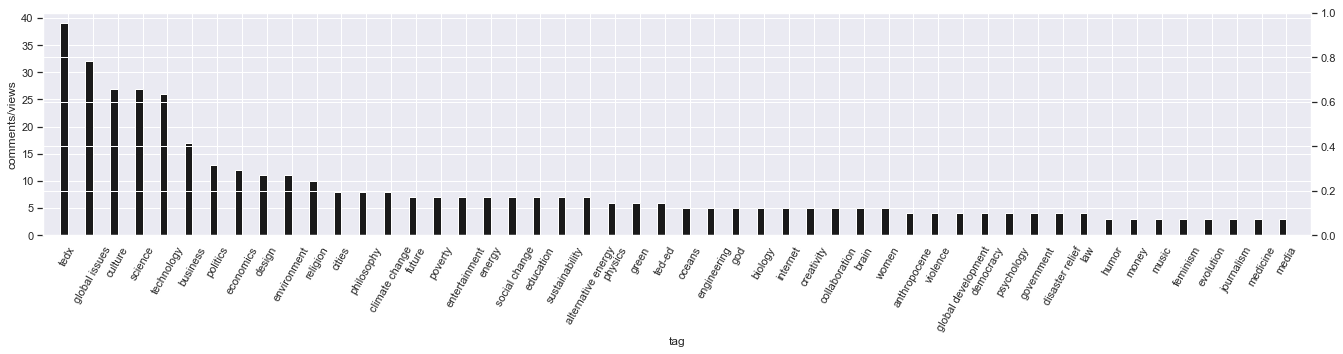

In [132]:
fig = plt.figure(figsize=(50,9)) # Create matplotlib figure

ax = fig.add_subplot(222) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .3

tag_grouped[0].plot(kind='bar',color='k',ax=ax,width=width, position=1)
# comment_top_10.comments.plot(kind='bar',color='grey', ax=ax2,width = width,position=0)

ax.grid(None, axis=1)
# ax2.grid(None)

ax.set_ylabel('comments/views')
# ax2.set_ylabel('#comments')

ax.set_xticklabels(ax.get_xticklabels(),rotation=60)

ax.set_xlim(-1,50)

### Q2: How does the viewers’ taste changed over time?

In [134]:
film_year_df = talks_df.copy()
film_year_df['film_date_normal'] = pd.to_datetime(film_year_df['film_date'],unit='s')
film_year_df.head()

film_year_df['film_date_normal'][0].year
# array([2010, 2011, 2012], dtype=int32)
film_year_df['year'] = film_year_df['film_date_normal'].apply(lambda x:x.year)


In [135]:
film_year_df.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,film_date_normal,year
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,2006-02-25,2006
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,2006-02-25,2006


In [136]:
film_year_df.year.value_counts()

2013    270
2011    270
2010    267
2012    267
2016    246
2015    239
2014    237
2009    232
2007    114
2017     98
2008     84
2005     66
2006     50
2003     33
2004     33
2002     27
1998      6
2001      5
1983      1
1991      1
1994      1
1990      1
1984      1
1972      1
Name: year, dtype: int64

* The #talks before 2002 is too low. So remove the cases.

In [137]:
film_year_df = film_year_df[film_year_df['year']>2001]

In [138]:
film_year_df.year.value_counts()

2013    270
2011    270
2012    267
2010    267
2016    246
2015    239
2014    237
2009    232
2007    114
2017     98
2008     84
2005     66
2006     50
2003     33
2004     33
2002     27
Name: year, dtype: int64

In [139]:
filmyear_tags_split_df_prep = pd.DataFrame(film_year_df['tags']).unstack().str.strip("['']").str.split("', '", expand=True)
# cv_tags_split_df_prep2 = cv_tags_split_df_prep.reset_index()
filmyear_tags_split_df_prep2 = filmyear_tags_split_df_prep.reset_index(level=0, drop=True)
filmyear_tags_split_df_prep2.head(2)
filmyear_tags_split_df_prep3 = filmyear_tags_split_df_prep2.merge(film_year_df, left_index = True, right_index = True)
# cv_tags_split_df_prep3.columns
filmyear_tags_split_df_prep3.shape
filmyear_tags_split_df = filmyear_tags_split_df_prep3.melt(id_vars = ['comments','description','duration','event','film_date','languages','main_speaker','name','num_speaker','published_date','ratings','related_talks', 'speaker_occupation','tags','title','url','views','film_date_normal','year'], value_name = "tag")
filmyear_tags_split_df.tag = filmyear_tags_split_df.tag.str.lower()

In [140]:
filmyear_tags_split_df.shape

(81056, 21)

In [141]:
filmyear_tags_split_df.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,related_talks,speaker_occupation,tags,title,url,views,film_date_normal,year,variable,tag
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,"[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,2006-02-25,2006,0,children
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,"[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,2006-02-25,2006,0,alternative energy


In [142]:
#technology

tech_df = filmyear_tags_split_df[filmyear_tags_split_df.tag=='technology']
tech_df_group = pd.DataFrame(tech_df.groupby('year').size())
tech_df_group.columns=['tag_with_tech']
tech_df_group

# filmyear_tags_split_df_group =  filmyear_tags_split_df.groupby('year').size()
filmyear_tags_split_df_group =  pd.DataFrame(film_year_df.groupby('year').size())
filmyear_tags_split_df_group.columns=['all']
filmyear_tags_split_df_group

result = pd.concat([filmyear_tags_split_df_group, tech_df_group], axis=1, sort=False)
result['talks_percent'] = result['tag_with_tech']/result['all']
result

# filmyear_tags_split_df_vies_eachyear = filmyear_tags_split_df.groupby('year').views.sum()
filmyear_tags_split_df_vies_eachyear = pd.DataFrame(film_year_df.groupby('year').views.sum())
filmyear_tags_split_df_vies_eachyear.columns=['all']
filmyear_tags_split_df_vies_eachyear 

tech_df_group_views_eachyear = pd.DataFrame(tech_df.groupby('year').views.sum())
tech_df_group_views_eachyear.columns=['tag_with_tech']
tech_df_group_views_eachyear

result2 = pd.concat([filmyear_tags_split_df_vies_eachyear, tech_df_group_views_eachyear], axis=1, sort=False)
result2['views_percent'] = result2['tag_with_tech']/result2['all']
result2

tech_talks_percent = pd.DataFrame(result['talks_percent'])
tech_views_percent = pd.DataFrame(result2['views_percent'])
tech_final_result = pd.concat([tech_talks_percent, tech_views_percent], axis=1, sort=False)
tech_final_result.head(5)

,talks_percent,views_percent
year,,
2002,0.407407,0.413505
2003,0.393939,0.285313
2004,0.303030,0.132135
2005,0.439394,0.325685
2006,0.320000,0.131043


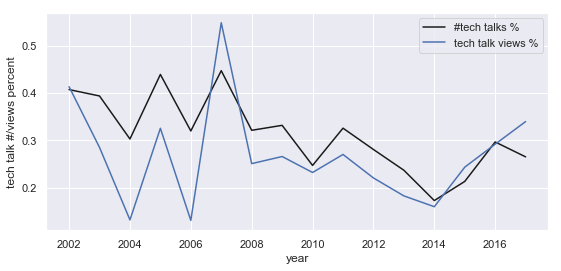

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

tech_plot = tech_final_result.copy()
tech_plot = tech_plot.reset_index()
tech_plot

fig = plt.figure(figsize=(9,4))
# ax = sns.lineplot(x="year", y="talks_percent", hue="event",data=tech_plot)
ax = sns.lineplot(x='year', y='talks_percent', data=tech_plot, color='k', label='#tech talks %')
ax = sns.lineplot(x='year', y='views_percent', data=tech_plot, label='tech talk views %')
ax.set(xlabel='year', ylabel='tech talk #/views percent')
plt.legend()
plt.show()

In [144]:
# science

tech_df = filmyear_tags_split_df[filmyear_tags_split_df.tag=='science']
tech_df_group = pd.DataFrame(tech_df.groupby('year').size())
tech_df_group.columns=['tag_with_tech']
tech_df_group

# filmyear_tags_split_df_group =  filmyear_tags_split_df.groupby('year').size()
filmyear_tags_split_df_group =  pd.DataFrame(film_year_df.groupby('year').size())
filmyear_tags_split_df_group.columns=['all']
filmyear_tags_split_df_group

result = pd.concat([filmyear_tags_split_df_group, tech_df_group], axis=1, sort=False)
result['talks_percent'] = result['tag_with_tech']/result['all']
result

# filmyear_tags_split_df_vies_eachyear = filmyear_tags_split_df.groupby('year').views.sum()
filmyear_tags_split_df_vies_eachyear = pd.DataFrame(film_year_df.groupby('year').views.sum())
filmyear_tags_split_df_vies_eachyear.columns=['all']
filmyear_tags_split_df_vies_eachyear 

tech_df_group_views_eachyear = pd.DataFrame(tech_df.groupby('year').views.sum())
tech_df_group_views_eachyear.columns=['tag_with_tech']
tech_df_group_views_eachyear

result2 = pd.concat([filmyear_tags_split_df_vies_eachyear, tech_df_group_views_eachyear], axis=1, sort=False)
result2['views_percent'] = result2['tag_with_tech']/result2['all']
result2

tech_talks_percent = pd.DataFrame(result['talks_percent'])
tech_views_percent = pd.DataFrame(result2['views_percent'])
tech_final_result = pd.concat([tech_talks_percent, tech_views_percent], axis=1, sort=False)
tech_final_result.head(2)


,talks_percent,views_percent
year,,
2002,0.333333,0.513786
2003,0.333333,0.227836


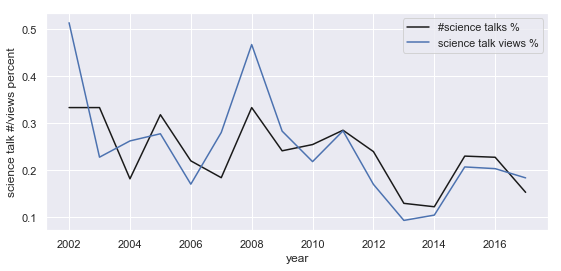

In [145]:
tech_plot = tech_final_result.copy()
tech_plot = tech_plot.reset_index()
tech_plot

fig = plt.figure(figsize=(9,4))
# ax = sns.lineplot(x="year", y="talks_percent", hue="event",data=tech_plot)
ax = sns.lineplot(x='year', y='talks_percent', data=tech_plot, color='k', label='#science talks %')
ax = sns.lineplot(x='year', y='views_percent', data=tech_plot, label='science talk views %')
ax.set(xlabel='year', ylabel='science talk #/views percent')
plt.legend()
plt.show()

In [146]:
# global issues

tech_df = filmyear_tags_split_df[filmyear_tags_split_df.tag=='global issues']
tech_df_group = pd.DataFrame(tech_df.groupby('year').size())
tech_df_group.columns=['tag_with_tech']
tech_df_group

# filmyear_tags_split_df_group =  filmyear_tags_split_df.groupby('year').size()
filmyear_tags_split_df_group =  pd.DataFrame(film_year_df.groupby('year').size())
filmyear_tags_split_df_group.columns=['all']
filmyear_tags_split_df_group

result = pd.concat([filmyear_tags_split_df_group, tech_df_group], axis=1, sort=False)
result['talks_percent'] = result['tag_with_tech']/result['all']
result

# filmyear_tags_split_df_vies_eachyear = filmyear_tags_split_df.groupby('year').views.sum()
filmyear_tags_split_df_vies_eachyear = pd.DataFrame(film_year_df.groupby('year').views.sum())
filmyear_tags_split_df_vies_eachyear.columns=['all']
filmyear_tags_split_df_vies_eachyear 

tech_df_group_views_eachyear = pd.DataFrame(tech_df.groupby('year').views.sum())
tech_df_group_views_eachyear.columns=['tag_with_tech']
tech_df_group_views_eachyear

result2 = pd.concat([filmyear_tags_split_df_vies_eachyear, tech_df_group_views_eachyear], axis=1, sort=False)
result2['views_percent'] = result2['tag_with_tech']/result2['all']
result2

tech_talks_percent = pd.DataFrame(result['talks_percent'])
tech_views_percent = pd.DataFrame(result2['views_percent'])
tech_final_result = pd.concat([tech_talks_percent, tech_views_percent], axis=1, sort=False)
tech_final_result.head(2)


,talks_percent,views_percent
year,,
2002,0.148148,0.149586
2003,0.212121,0.175993


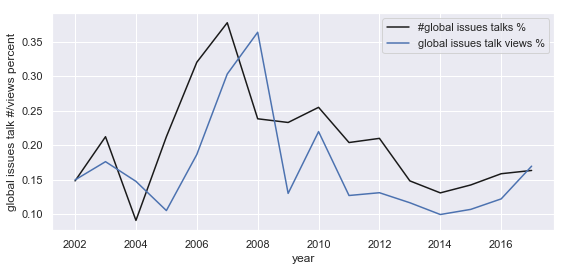

In [147]:
tech_plot = tech_final_result.copy()
tech_plot = tech_plot.reset_index()
tech_plot

fig = plt.figure(figsize=(9,4))
# ax = sns.lineplot(x="year", y="talks_percent", hue="event",data=tech_plot)
ax = sns.lineplot(x='year', y='talks_percent', data=tech_plot, color='k', label='#global issues talks %')
ax = sns.lineplot(x='year', y='views_percent', data=tech_plot, label='global issues talk views %')
ax.set(xlabel='year', ylabel='global issues talk #/views percent')
plt.legend()
plt.show()

### Q3: How to become a cool person in your field?

In [37]:
occu = talks_df.copy()
occu = occu.dropna(subset=['speaker_occupation'])

In [38]:
occu.count()

comments              2544
description           2544
duration              2544
event                 2544
film_date             2544
languages             2544
main_speaker          2544
name                  2544
num_speaker           2544
published_date        2544
ratings               2544
related_talks         2544
speaker_occupation    2544
tags                  2544
title                 2544
url                   2544
views                 2544
dtype: int64

In [39]:
occu['speaker_occupation'] = occu['speaker_occupation'].str.replace(';','/')
occu['speaker_occupation'] = occu['speaker_occupation'].str.replace(',','/')
occu['speaker_occupation'] = occu['speaker_occupation'].str.replace(' and ','/')

In [40]:
occu_list = occu.copy()
occu_list['occu_list'] = occu_list['speaker_occupation'].str.split('/')
occu_list.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,occu_list
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,"[Author, educator]"
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,[Climate advocate]


In [41]:
occu_split_df = occu_list.copy()
res = occu_split_df.set_index(['comments', 'description','duration','event','film_date','languages','main_speaker','name','num_speaker','published_date','ratings','related_talks','speaker_occupation','tags','title','url','views'])['occu_list'].apply(pd.Series).stack()
res = res.reset_index()
res.columns = ['comments', 'description','duration','event','film_date','languages','main_speaker','name','num_speaker','published_date','ratings','related_talks','speaker_occupation','tags','title','url','views','occu_num','occu']
res.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,occu_num,occu
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,0,Author
1,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,1,educator
2,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,0,Climate advocate
3,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,0,Technology columnist
4,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,0,Activist for environmental justice


In [42]:
res['occu']=res['occu'].str.lower().str.strip()
res.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,occu_num,occu
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,0,author
1,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,1,educator
2,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,0,climate advocate
3,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,0,technology columnist
4,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,0,activist for environmental justice


In [43]:
res.shape

(3183, 19)

In [44]:
occu_root = res.copy()
occupation_list = occu_root['occu'].tolist()

In [45]:
len(occupation_list)

3183

In [46]:
root_words_list = []
for ele in occupation_list:
    doc = nlp(ele)
    for token in doc:
        if token.dep_=="ROOT":
            root_words_list.append(token.text)
        else:
            pass

In [47]:
len(root_words_list)

3183

In [48]:
occu_root['root_word'] = root_words_list

In [49]:
occu_root.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,occu_num,occu,root_word
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,0,author,author
1,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,1,educator,educator


In [50]:
w2v_mod = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300-SLIM.bin", binary=True)

In [51]:
occu_root_with_tag = occu_root.copy()
# occu_root_with_tag['tag_list'] = occu_root_with_tag['tags'].str.strip("['']").str.split("', '")
occu_root_with_tag['tag_list'] = occu_root_with_tag['tags'].str.strip("['']").apply(lambda x: re.split('\', \'| ',x))
occu_root_with_tag.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,related_talks,speaker_occupation,tags,title,url,views,occu_num,occu,root_word,tag_list
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,"[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,0,author,author,"[children, creativity, culture, dance, educati..."
1,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,"[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,1,educator,educator,"[children, creativity, culture, dance, educati..."
2,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,"[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,0,climate advocate,advocate,"[alternative, energy, cars, climate, change, c..."
3,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,"[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,0,technology columnist,columnist,"[computers, entertainment, interface, design, ..."
4,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,"[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,0,activist for environmental justice,activist,"[MacArthur, grant, activism, business, cities,..."


In [52]:
tag_list_list = occu_root_with_tag.tag_list.tolist()
root_word_list = occu_root_with_tag.root_word.tolist()
similarity_list = []
for i in range(len(tag_list_list)):
    root_word = root_word_list[i]
    tag_list = tag_list_list[i]
    similarity = []
    for ele in tag_list:
        try:
            value = w2v_mod.similarity(root_word, ele)
            similarity.append(value)
        except:
            value = 0
            similarity.append(value)
    sum_all = sum(similarity)
    len_all = len(similarity)
    mean_all = sum_all/len_all
#     similarity_list.append(min(similarity))
    similarity_list.append(mean_all)
    
#     w2v_mod.similarity(root_word, each word in tags list)

In [53]:
len(similarity_list)

3183

In [54]:
occu_root_with_tag['similarity_value'] = similarity_list
occu_root_with_tag.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,speaker_occupation,tags,title,url,views,occu_num,occu,root_word,tag_list,similarity_value
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,0,author,author,"[children, creativity, culture, dance, educati...",0.097782
1,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,...,Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,1,educator,educator,"[children, creativity, culture, dance, educati...",0.275355
2,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,...,Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,0,climate advocate,advocate,"[alternative, energy, cars, climate, change, c...",0.115960
3,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,...,Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,0,technology columnist,columnist,"[computers, entertainment, interface, design, ...",0.019203
4,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,...,Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,0,activist for environmental justice,activist,"[MacArthur, grant, activism, business, cities,...",0.164001


In [55]:
occu_root_with_tag_order = occu_root_with_tag.sort_values('similarity_value')

In [56]:
cool_talk_df = occu_root_with_tag_order.head(3)

In [57]:
cool_talk_df

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,speaker_occupation,tags,title,url,views,occu_num,occu,root_word,tag_list,similarity_value
1875,127,What's a proven way to lower your energy costs...,491,TED2013,1362009600,35,Alex Laskey,Alex Laskey: How behavioral science can lower ...,1,1370358008,...,Energy software maker,"['behavioral economics', 'energy', 'psychology']",How behavioral science can lower your energy bill,https://www.ted.com/talks/alex_laskey_how_beha...,1089949,0,energy software maker,maker,"[behavioral, economics, energy, psychology]",-0.038392
2113,80,"On January 8, 2011, Congresswoman Gabby Giffor...",1128,TED2014,1395360000,23,Gabby Giffords and Mark Kelly,Gabby Giffords and Mark Kelly: Be passionate. ...,1,1397229849,...,Former U.S. Representative/NASA astronaut/ sur...,"['Guns', 'violence']",Be passionate. Be courageous. Be your best.,https://www.ted.com/talks/gabby_giffords_and_m...,1048304,1,nasa astronaut,astronaut,"[Guns, violence]",-0.034166
1610,227,What kind of data is your cell phone company c...,596,TEDGlobal 2012,1340755200,34,Malte Spitz,Malte Spitz: Your phone company is watching,1,1343142603,...,Politician/ data activist,"['Europe', 'data', 'technology', 'telecom']",Your phone company is watching,https://www.ted.com/talks/malte_spitz_your_pho...,1619108,1,data activist,activist,"[Europe, data, technology, telecom]",-0.020427


In [58]:
cool_talk_df.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'occu_num', 'occu', 'root_word', 'tag_list',
       'similarity_value'],
      dtype='object')

> database export part is at the end of this notebook

### Q4: What are we really talking about?

In [ ]:
talks_df.shape

In [3]:
trans_df  = pd.read_csv('ted-talks/transcripts.csv')
trans_df.head()

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


In [4]:
trans_df.shape

(2467, 2)

In [33]:
all_data = talks_df.copy()
all_data = all_data.join(trans_df.set_index('url'), on='url')
all_data.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre..."


In [34]:
data_all_without_na = all_data.copy()
data_all_without_na = data_all_without_na.dropna(subset=['transcript'])

In [35]:
data_all_without_na.head(2)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre..."


In [59]:
cool_talk_df

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,speaker_occupation,tags,title,url,views,occu_num,occu,root_word,tag_list,similarity_value
1875,127,What's a proven way to lower your energy costs...,491,TED2013,1362009600,35,Alex Laskey,Alex Laskey: How behavioral science can lower ...,1,1370358008,...,Energy software maker,"['behavioral economics', 'energy', 'psychology']",How behavioral science can lower your energy bill,https://www.ted.com/talks/alex_laskey_how_beha...,1089949,0,energy software maker,maker,"[behavioral, economics, energy, psychology]",-0.038392
2113,80,"On January 8, 2011, Congresswoman Gabby Giffor...",1128,TED2014,1395360000,23,Gabby Giffords and Mark Kelly,Gabby Giffords and Mark Kelly: Be passionate. ...,1,1397229849,...,Former U.S. Representative/NASA astronaut/ sur...,"['Guns', 'violence']",Be passionate. Be courageous. Be your best.,https://www.ted.com/talks/gabby_giffords_and_m...,1048304,1,nasa astronaut,astronaut,"[Guns, violence]",-0.034166
1610,227,What kind of data is your cell phone company c...,596,TEDGlobal 2012,1340755200,34,Malte Spitz,Malte Spitz: Your phone company is watching,1,1343142603,...,Politician/ data activist,"['Europe', 'data', 'technology', 'telecom']",Your phone company is watching,https://www.ted.com/talks/malte_spitz_your_pho...,1619108,1,data activist,activist,"[Europe, data, technology, telecom]",-0.020427


In [60]:
cool_talk_url_list = cool_talk_df.url.tolist()
cool_talk_url_list

['https://www.ted.com/talks/alex_laskey_how_behavioral_science_can_lower_your_energy_bill\n',
 'https://www.ted.com/talks/gabby_giffords_and_mark_kelly_be_passionate_be_courageous_be_your_best\n',
 'https://www.ted.com/talks/malte_spitz_your_phone_company_is_watching\n']

In [61]:
cool_talk_transcript = data_all_without_na.copy()
cool_talk_transcript = cool_talk_transcript[cool_talk_transcript.url.isin(cool_talk_url_list)]
cool_talk_transcript

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
1296,227,What kind of data is your cell phone company c...,596,TEDGlobal 2012,1340755200,34,Malte Spitz,Malte Spitz: Your phone company is watching,1,1343142603,"[{'id': 24, 'name': 'Persuasive', 'count': 293...","[{'id': 1268, 'hero': 'https://pe.tedcdn.com/i...","Politician, data activist","['Europe', 'data', 'technology', 'telecom']",Your phone company is watching,https://www.ted.com/talks/malte_spitz_your_pho...,1619108,Hi. This is my mobile phone. A mobile phone ca...
1518,127,What's a proven way to lower your energy costs...,491,TED2013,1362009600,35,Alex Laskey,Alex Laskey: How behavioral science can lower ...,1,1370358008,"[{'id': 8, 'name': 'Informative', 'count': 325...","[{'id': 20, 'hero': 'https://pe.tedcdn.com/ima...",Energy software maker,"['behavioral economics', 'energy', 'psychology']",How behavioral science can lower your energy bill,https://www.ted.com/talks/alex_laskey_how_beha...,1089949,How many of you have checked your email today?...
1721,80,"On January 8, 2011, Congresswoman Gabby Giffor...",1128,TED2014,1395360000,23,Gabby Giffords and Mark Kelly,Gabby Giffords and Mark Kelly: Be passionate. ...,1,1397229849,"[{'id': 1, 'name': 'Beautiful', 'count': 220},...","[{'id': 1566, 'hero': 'https://pe.tedcdn.com/i...",Former U.S. Representative and NASA astronaut;...,"['Guns', 'violence']",Be passionate. Be courageous. Be your best.,https://www.ted.com/talks/gabby_giffords_and_m...,1048304,"Pat Mitchell: That day, January 8, 2011, began..."


In [74]:
text0 = cool_talk_transcript.transcript[1296]
len(text0)

6429

In [75]:
text_list = []

text = text0

exclude = set(string.punctuation)
text_new = ''.join(ch for ch in text if ch not in exclude)
text_nonpunc_1 = re.sub(r'[^\w\s]', '', text_new)
text_nonpunc_2 = re.sub(r'[\t\v\r\f\_\(\)\,\.]', '', text_nonpunc_1)
text_nonpunc= re.sub(re.compile('\n+'), ' ', text_nonpunc_2)

text_low_nonpunc = text_nonpunc.lower()
words = text_low_nonpunc.split()
text_low_nonstop_nonpunc = []
for word in words:
    if word not in STOP_WORDS:
        text_low_nonstop_nonpunc.append(word)

final_text_list = [ele for ele in text_low_nonstop_nonpunc if ele.strip()]

text_list.append(final_text_list)


In [76]:
len(final_text_list)

447

In [77]:
data_words = final_text_list
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [78]:
def remove_stopwords(texts):
    list_word = []
    add_list = ["be","not","s"]
    for word in texts:
        if (word.strip() not in STOP_WORDS and word.strip() not in add_list):
            list_word.append(word.strip())
    return list_word

def make_bigrams(texts):
    return [bigram_mod[texts]]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[texts]]]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    add_list = ["be","not","s"]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if (token.pos_ in allowed_postags and token.text not in STOP_WORDS and token.text not in add_list)])
    return texts_out

In [79]:
data_words_nostops = data_words
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [81]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [82]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=1, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [83]:
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [84]:
result = lda_model.print_topics()[0][1]
result_list = re.split('\*\"|\" \+ |\"',result)

In [85]:
words = []
numbers = []
for i in range(len(result_list)-1):
    if i%2:
        words.append(result_list[i])
    else:
        numbers.append(float(result_list[i]))

In [86]:
result_df = pd.DataFrame()
result_df['weight'] = numbers
result_df['word'] = words
result_df

,weight,word
0,0.035,information
1,0.035,phone
2,0.026,mobile
3,0.023,want
4,0.019,say
5,0.018,store
6,0.018,company
7,0.013,life
8,0.013,people
9,0.013,time


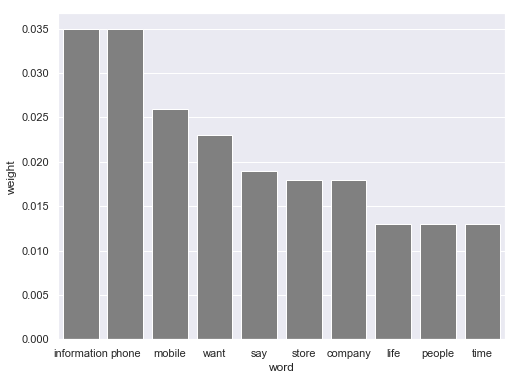

In [87]:
import seaborn as sns
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x="word", y="weight", data=result_df, color='grey')

In [95]:
text1 = cool_talk_transcript.transcript[1518]
len(text1)

7255

In [96]:
text_list = []

text = text1

exclude = set(string.punctuation)
text_new = ''.join(ch for ch in text if ch not in exclude)
text_nonpunc_1 = re.sub(r'[^\w\s]', '', text_new)
text_nonpunc_2 = re.sub(r'[\t\v\r\f\_\(\)\,\.]', '', text_nonpunc_1)
text_nonpunc= re.sub(re.compile('\n+'), ' ', text_nonpunc_2)

text_low_nonpunc = text_nonpunc.lower()
words = text_low_nonpunc.split()
text_low_nonstop_nonpunc = []

nlp.vocab["s"].is_stop = True
nlp.vocab["be"].is_stop = True
nlp.vocab["not"].is_stop = True
for word in words:
    if word.strip() not in STOP_WORDS:
        text_low_nonstop_nonpunc.append(word.strip())

final_text_list = [ele for ele in text_low_nonstop_nonpunc if ele.strip()]

In [97]:
data_words = final_text_list

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=300)
trigram = gensim.models.Phrases(bigram[data_words], threshold=300)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [98]:
data_words_bigrams = make_bigrams(data_words)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [99]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [100]:
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=1, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [101]:
result = lda_model2.print_topics()[0][1]
result_list = re.split('\*\"|\" \+ |\"',result)

words = []
numbers = []
for i in range(len(result_list)-1):
    if i%2:
        words.append(result_list[i])
    else:
        numbers.append(float(result_list[i]))
        
result_df = pd.DataFrame()
result_df['weight'] = numbers
result_df['word'] = words
result_df

,weight,word
0,0.030,energy
1,0.013,save
2,0.013,year
3,0.013,people
4,0.011,message
5,0.011,turn
6,0.010,coal
7,0.010,not
8,0.008,waste
9,0.008,home


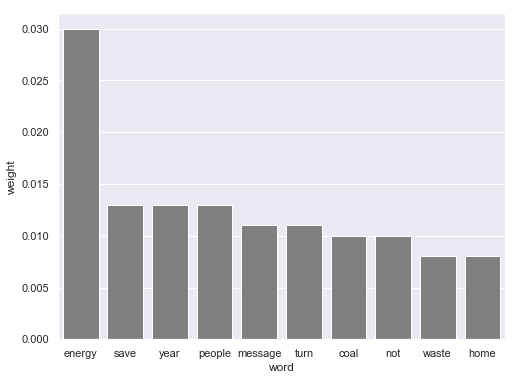

In [102]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x="word", y="weight", data=result_df, color='grey')

In [103]:
text2 = cool_talk_transcript.transcript[1721]
len(text2)

15278

In [104]:
text_list = []

text = text2

exclude = set(string.punctuation)
text_new = ''.join(ch for ch in text if ch not in exclude)
text_nonpunc_1 = re.sub(r'[^\w\s]', '', text_new)
text_nonpunc_2 = re.sub(r'[\t\v\r\f\_\(\)\,\.]', '', text_nonpunc_1)
text_nonpunc= re.sub(re.compile('\n+'), ' ', text_nonpunc_2)

text_low_nonpunc = text_nonpunc.lower()
words = text_low_nonpunc.split()
text_low_nonstop_nonpunc = []
for word in words:
    if word not in STOP_WORDS:
        text_low_nonstop_nonpunc.append(word)

final_text_list = [ele for ele in text_low_nonstop_nonpunc if ele.strip()]

text_list.append(final_text_list)

In [105]:
data_words = final_text_list

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [107]:
data_words_bigrams = make_bigrams(data_words)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(data_lemmatized[:1])

In [108]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [109]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=1, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

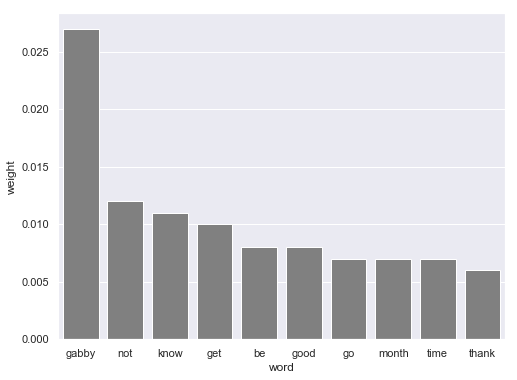

In [110]:
result = lda_model.print_topics()[0][1]
result_list = re.split('\*\"|\" \+ |\"',result)

words = []
numbers = []
for i in range(len(result_list)-1):
    if i%2:
        words.append(result_list[i])
    else:
        numbers.append(float(result_list[i]))
        
result_df = pd.DataFrame()
result_df['weight'] = numbers
result_df['word'] = words
result_df

fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x="word", y="weight", data=result_df, color='grey')

### Webpage Part: Put Data into Sqlite Database

In [ ]:
occu_root_with_tag

In [36]:
cool_talk_df

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,speaker_occupation,tags,title,url,views,occu_num,occu,root_word,tag_list,similarity_value
1875,127,What's a proven way to lower your energy costs...,491,TED2013,1362009600,35,Alex Laskey,Alex Laskey: How behavioral science can lower ...,1,1370358008,...,Energy software maker,"['behavioral economics', 'energy', 'psychology']",How behavioral science can lower your energy bill,https://www.ted.com/talks/alex_laskey_how_beha...,1089949,0,energy software maker,maker,"[behavioral, economics, energy, psychology]",-0.038392
2113,80,"On January 8, 2011, Congresswoman Gabby Giffor...",1128,TED2014,1395360000,23,Gabby Giffords and Mark Kelly,Gabby Giffords and Mark Kelly: Be passionate. ...,1,1397229849,...,Former U.S. Representative/NASA astronaut/ sur...,"['Guns', 'violence']",Be passionate. Be courageous. Be your best.,https://www.ted.com/talks/gabby_giffords_and_m...,1048304,1,nasa astronaut,astronaut,"[Guns, violence]",-0.034166
1610,227,What kind of data is your cell phone company c...,596,TEDGlobal 2012,1340755200,34,Malte Spitz,Malte Spitz: Your phone company is watching,1,1343142603,...,Politician/ data activist,"['Europe', 'data', 'technology', 'telecom']",Your phone company is watching,https://www.ted.com/talks/malte_spitz_your_pho...,1619108,1,data activist,activist,"[Europe, data, technology, telecom]",-0.020427


In [37]:
cool_talk_db = cool_talk_df[['main_speaker','title','speaker_occupation','url','root_word','tags','similarity_value']]

In [38]:
cool_talk_db

,main_speaker,title,speaker_occupation,url,root_word,tags,similarity_value
1875,Alex Laskey,How behavioral science can lower your energy bill,Energy software maker,https://www.ted.com/talks/alex_laskey_how_beha...,maker,"['behavioral economics', 'energy', 'psychology']",-0.038392
2113,Gabby Giffords and Mark Kelly,Be passionate. Be courageous. Be your best.,Former U.S. Representative/NASA astronaut/ sur...,https://www.ted.com/talks/gabby_giffords_and_m...,astronaut,"['Guns', 'violence']",-0.034166
1610,Malte Spitz,Your phone company is watching,Politician/ data activist,https://www.ted.com/talks/malte_spitz_your_pho...,activist,"['Europe', 'data', 'technology', 'telecom']",-0.020427


In [56]:
occu_database = occu_root_with_tag[['main_speaker','title','speaker_occupation','url','root_word','tags','similarity_value']]

In [57]:
engine = create_engine('sqlite://', echo=False)
engine = sqlalchemy.create_engine('sqlite:///cooltalk.sqlite', echo=False)

occu_database.to_sql('info', con=engine, if_exists='append')

In [58]:
occu_database.shape

(3183, 7)